In [1]:
import numpy as np
from PIL import Image
import os
import json

In [2]:
def load_single_ring_dataset(directory):
    images = []
    labels = []
    
    # Read labels from JSON file
    with open(os.path.join(directory, 'labels.json'), 'r') as f:
        labels_data = json.load(f)
    
    # Load images and process labels
    for i, label in enumerate(labels_data):
        filename = f'ring_image_{i}.png'
        img_path = os.path.join(directory, filename)
        if os.path.exists(img_path):
            # Load and normalize image
            img = Image.open(img_path).convert('L')
            img_array = np.array(img).reshape(-1).astype('float32') / 255
            images.append(img_array)
            
            # Process label
            processed_label = [
                label['center'][0] / img.width,  # Normalize x coordinate
                label['center'][1] / img.height,  # Normalize y coordinate
                label['radius'] / img.width,  # Normalize radius
                label['thickness'],
                label['deformation']
            ]
            labels.append(processed_label)
        else:
            print(f"Warning: Image {filename} not found. Skipping.")
    
    # Ensure we have the same number of images and labels
    if len(images) != len(labels):
        print(f"Warning: Number of images ({len(images)}) does not match number of labels ({len(labels)})")
    
    return np.array(images), np.array(labels)

In [3]:
images, labels = load_single_ring_dataset('single_ring_dataset')

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import random

def visualize_ring_dataset(images, labels, num_samples=5, max_cols=4):
    # Ensure we don't try to display more samples than we have
    num_samples = min(num_samples, len(images))
    
    # Randomly select indices
    selected_indices = random.sample(range(len(images)), num_samples)
    
    # Calculate number of rows and columns
    num_cols = min(num_samples, max_cols)
    num_rows = (num_samples - 1) // num_cols + 1
    
    # Calculate figure size (assuming each subplot is 3x3 inches)
    figsize = (num_cols * 3, num_rows * 3)
    
    # Set up the plot
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if num_rows * num_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    img_size = int(np.sqrt(images[0].shape[0]))  # Assuming square images
    
    for i, idx in enumerate(selected_indices):
        ax = axes[i]
        
        # Reshape and display the image
        img = images[idx].reshape((img_size, img_size))
        ax.imshow(img, cmap='gray')
        
        # Extract label information
        center_x, center_y, radius, thickness, deformation = labels[idx]
        
        # Denormalize center coordinates and radius
        center_x *= img_size - 1
        center_y *= img_size - 1
        radius *= img_size - 1
        
        # Add a circle to represent the ring
        circle = Circle((center_x, center_y), radius, fill=False, color='red')
        ax.add_patch(circle)
        
        # Add text with ring properties
        ax.text(0.05, 1.3, f"Center: ({center_x:.1f}, {center_y:.1f})\nRadius: {radius:.1f}\nThickness: {thickness:.2f}\nDeformation: {deformation:.2f}",
                transform=ax.transAxes, verticalalignment='top', color='red', fontsize=10)
        
        ax.axis('off')
    
    # Remove any unused subplots
    for i in range(num_samples, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

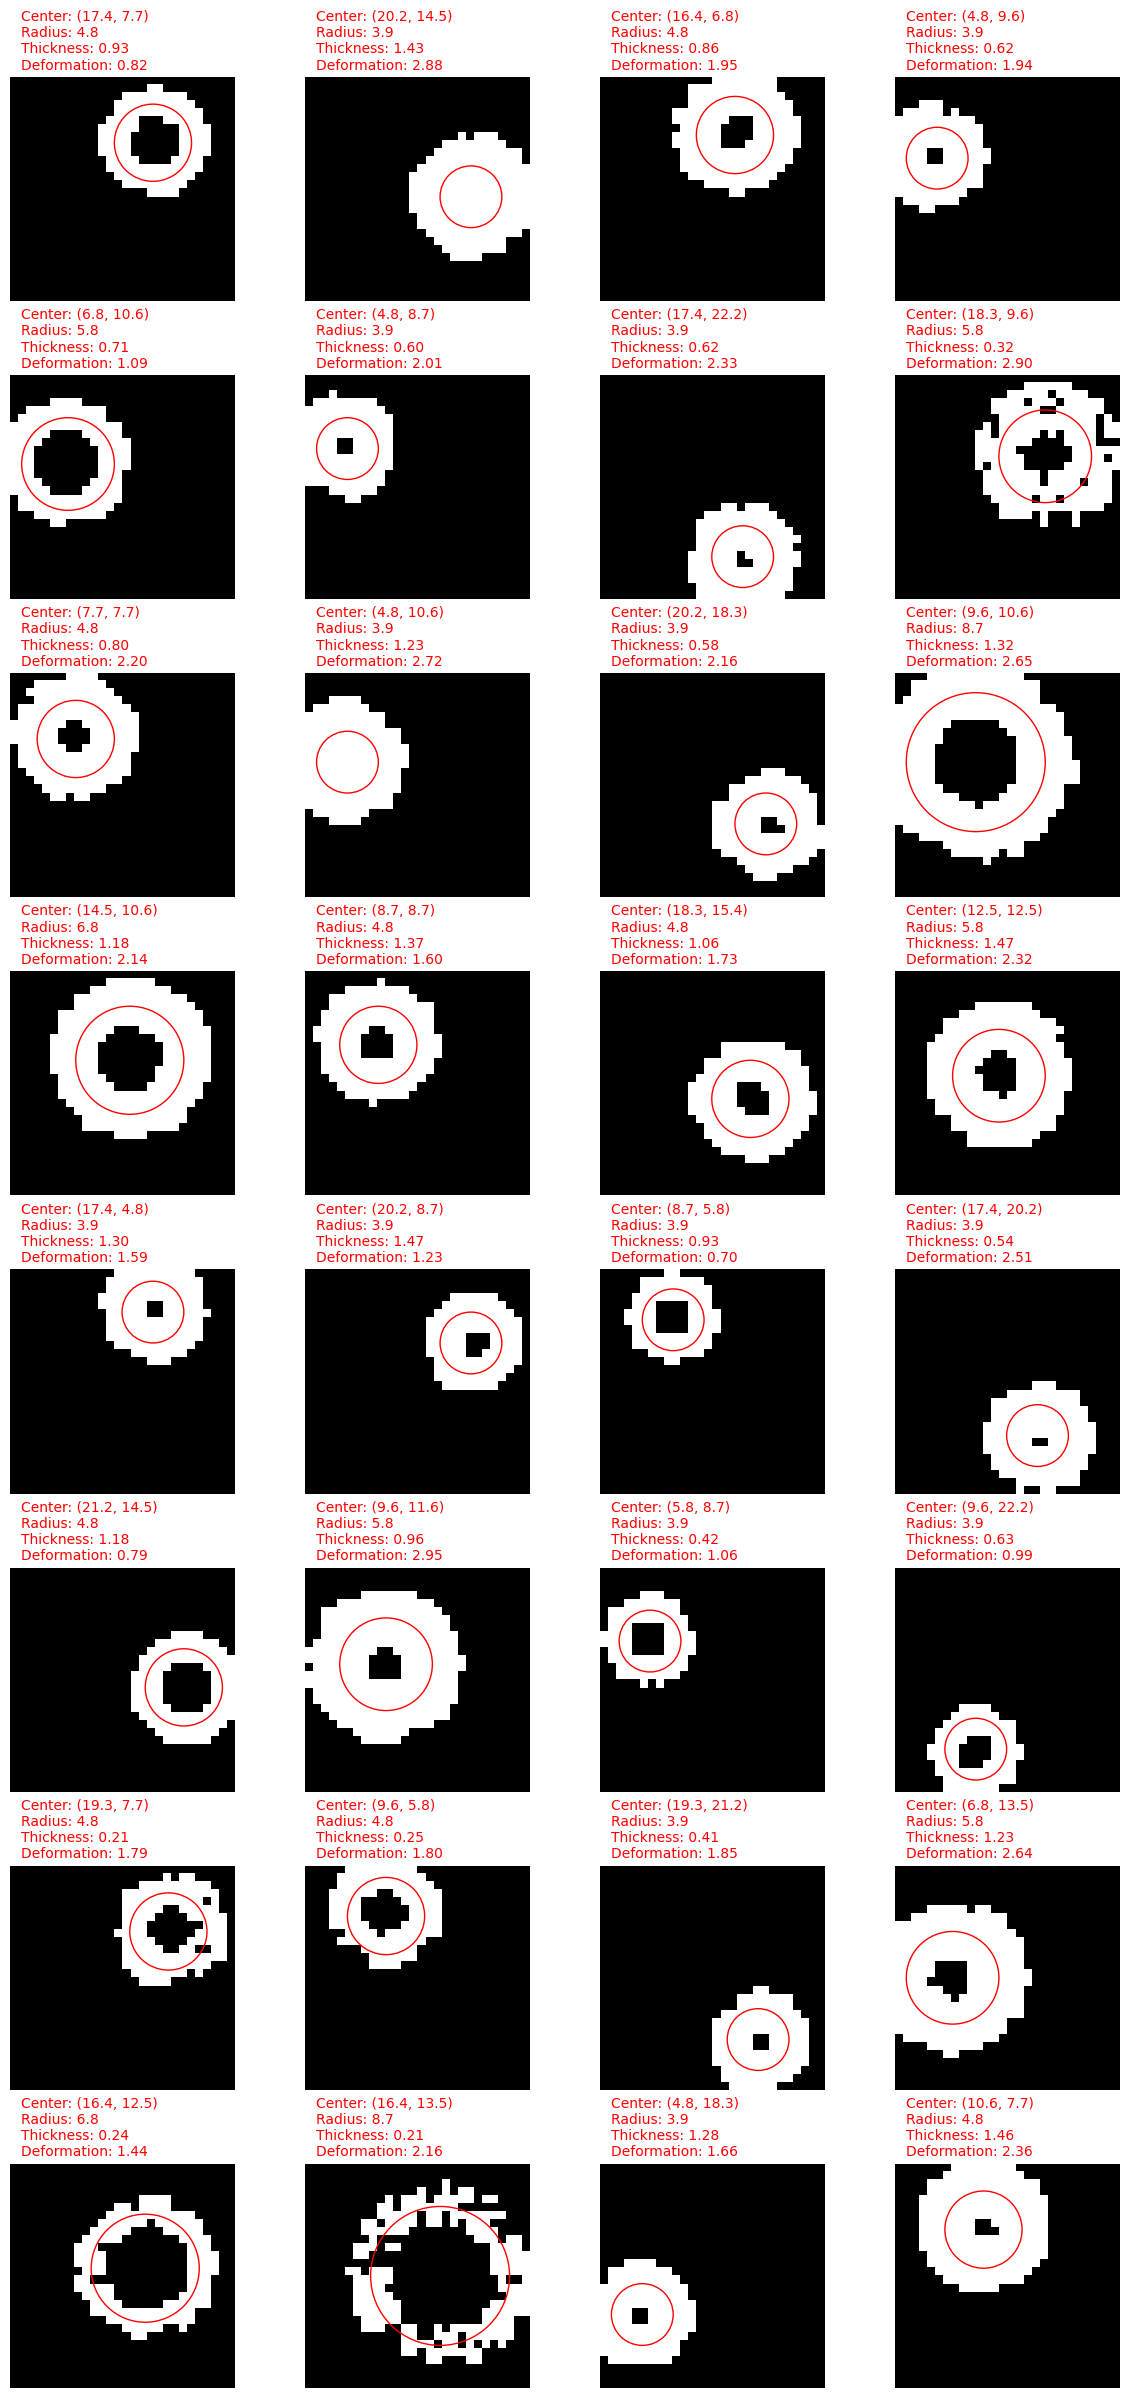

In [5]:
# Visualize some samples
visualize_ring_dataset(images, labels, num_samples=32)

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.model_selection import train_test_split

def create_ring_cnn_model(img_size):
    model = models.Sequential([
        layers.Input(shape=(img_size, img_size, 1)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(5)  # 5 output parameters: center_x, center_y, radius, thickness, deformation
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def prepare_data(images, labels, img_size):
    # Reshape images to (img_size, img_size, 1)
    X = images.reshape(images.shape[0], img_size, img_size, 1)
    y = np.array(labels)
    return X, y

def split_data(images, labels, test_size=0.2, random_state=42):
    return train_test_split(images, labels, test_size=test_size, random_state=random_state)

def train_ring_cnn_model(X_train, y_train, X_val, y_val, img_size, epochs=20, batch_size=100):
    # Create and compile the model
    model = create_ring_cnn_model(img_size)
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    
    return model, history

def evaluate_ring_cnn_model(model, X_test, y_test):
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test loss: {loss:.4f}")
    print(f"Test MAE: {mae:.4f}")
    
    # Make predictions on a few samples
    num_samples = 5
    sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
    sample_images = X_test[sample_indices]
    sample_labels = y_test[sample_indices]
    predictions = model.predict(sample_images)
    
    print("\Example Predictions:")
    for i in range(num_samples):
        print(f"Sample {i+1}:")
        print(f"True values: {sample_labels[i]}")
        print(f"Predictions: {predictions[i]}")
        print()

<>:59: SyntaxWarning: invalid escape sequence '\E'
<>:59: SyntaxWarning: invalid escape sequence '\E'
/var/folders/r5/jldxfm3172j6qxcq0bxhyp4h0000gn/T/ipykernel_88816/1057906574.py:59: SyntaxWarning: invalid escape sequence '\E'
  print("\Example Predictions:")


In [7]:
images, labels = load_single_ring_dataset('single_ring_dataset')
img_size = int(np.sqrt(images[0].shape[0]))

#Split the data
train_images, val_images, train_labels, val_labels = split_data(images, labels)

#Prepare the data
X_train, y_train = prepare_data(train_images, train_labels, img_size)
X_val, y_val = prepare_data(val_images, val_labels, img_size)

#Train the model
model, history = train_ring_cnn_model(X_train, y_train, X_val, y_val, img_size)

#Evaluate the model
evaluate_ring_cnn_model(model, X_val, y_val)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2578 - mae: 0.3273 - val_loss: 0.0578 - val_mae: 0.1484
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0504 - mae: 0.1345 - val_loss: 0.0372 - val_mae: 0.1162
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0352 - mae: 0.1137 - val_loss: 0.0344 - val_mae: 0.1204
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0296 - mae: 0.1039 - val_loss: 0.0289 - val_mae: 0.0983
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0253 - mae: 0.0936 - val_loss: 0.0255 - val_mae: 0.0945
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0238 - mae: 0.0896 - val_loss: 0.0342 - val_mae: 0.1066
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0239 - mae: 0.0893 - val_loss: 0.0325 - val_mae: 0.1040
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0244 - mae: 0.0900 - val_loss: 0.0224 - val_mae: 0.0857
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.020

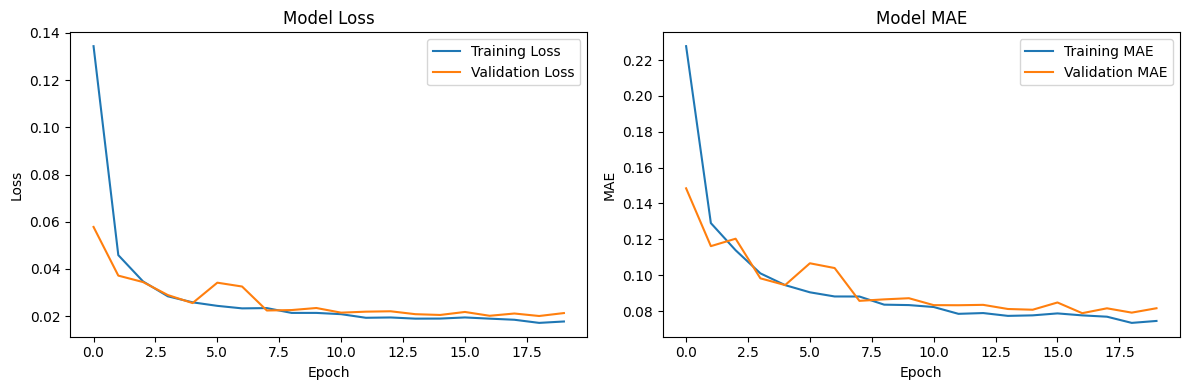

In [8]:
# If you want to visualize the training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns
import math

def plot_prediction_examples(model, images, labels, img_size, num_samples=5, max_cols=4):
    # Ensure we don't try to display more samples than we have
    num_samples = min(num_samples, len(images))
    
    # Randomly select indices
    selected_indices = random.sample(range(len(images)), num_samples)
    
    # Calculate number of rows and columns
    num_cols = min(num_samples, max_cols)
    num_rows = (num_samples - 1) // num_cols + 1
    
    # Calculate figure size (assuming each subplot is 3x3 inches)
    figsize = (num_cols * 3, num_rows * 4)
    
    # Set up the plot
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if num_rows * num_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Prepare data for prediction
    X = images[selected_indices].reshape(-1, img_size, img_size, 1)
    y_true = labels[selected_indices]
    y_pred = model.predict(X)
    
    for i, idx in enumerate(selected_indices):
        ax = axes[i]
        
        # Reshape and display the image
        img = images[idx].reshape((img_size, img_size))
        ax.imshow(img, cmap='gray')
        
        # Extract true and predicted label information
        true_center_x, true_center_y, true_radius, true_thickness, true_deformation = y_true[i]
        pred_center_x, pred_center_y, pred_radius, pred_thickness, pred_deformation = y_pred[i]
        
        # Denormalize center coordinates and radius
        true_center_x *= img_size - 1
        true_center_y *= img_size - 1
        true_radius *= img_size - 1
        pred_center_x *= img_size - 1
        pred_center_y *= img_size - 1
        pred_radius *= img_size - 1
        
        # Add circles to represent the true and predicted rings
        true_circle = Circle((true_center_x, true_center_y), true_radius, fill=False, color='red', label='True')
        pred_circle = Circle((pred_center_x, pred_center_y), pred_radius, fill=False, color='cyan', label='Predicted')
        ax.add_patch(true_circle)
        ax.add_patch(pred_circle)
        
        # Add text with ring properties (true and predicted)
        ax.text(0.05, 1.35, 
                f"True (Red) | Predicted (Cyan)\n"
                f"Center: ({true_center_x:.1f}, {true_center_y:.1f}) | ({pred_center_x:.1f}, {pred_center_y:.1f})\n"
                f"Radius: {true_radius:.1f} | {pred_radius:.1f}\n"
                f"Thickness: {true_thickness:.2f} | {pred_thickness:.2f}\n"
                f"Deformation: {true_deformation:.2f} | {pred_deformation:.2f}",
                transform=ax.transAxes, verticalalignment='top', fontsize=10)
        
        ax.axis('off')
    
    # Remove any unused subplots
    for i in range(num_samples, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()
    
def plot_relative_error_histograms(y_true, y_pred):
    param_names = ['Center X', 'Center Y', 'Radius', 'Thickness', 'Deformation']
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, name in enumerate(param_names):
        relative_error = (y_true[:, i] - y_pred[:, i]) / y_true[:, i]
        axes[i].hist(relative_error, bins=50, edgecolor='black')
        axes[i].set_title(f'Relative Error: {name}')
        axes[i].set_xlabel('(True - Predicted) / True')
        axes[i].set_ylabel('Frequency')

    axes[-1].axis('off')  # Remove the last empty subplot
    plt.tight_layout()
    plt.show()

def plot_parameter_correlations(y_true, y_pred):
    param_names = ['Center X', 'Center Y', 'Radius', 'Thickness', 'Deformation']
    
    # Calculate absolute errors
    errors = np.abs(y_true - y_pred)

    # Create correlation matrix
    corr_matrix = np.corrcoef(errors.T)

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
                xticklabels=param_names, yticklabels=param_names)
    plt.title('Correlation of Absolute Errors Between Parameters')
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


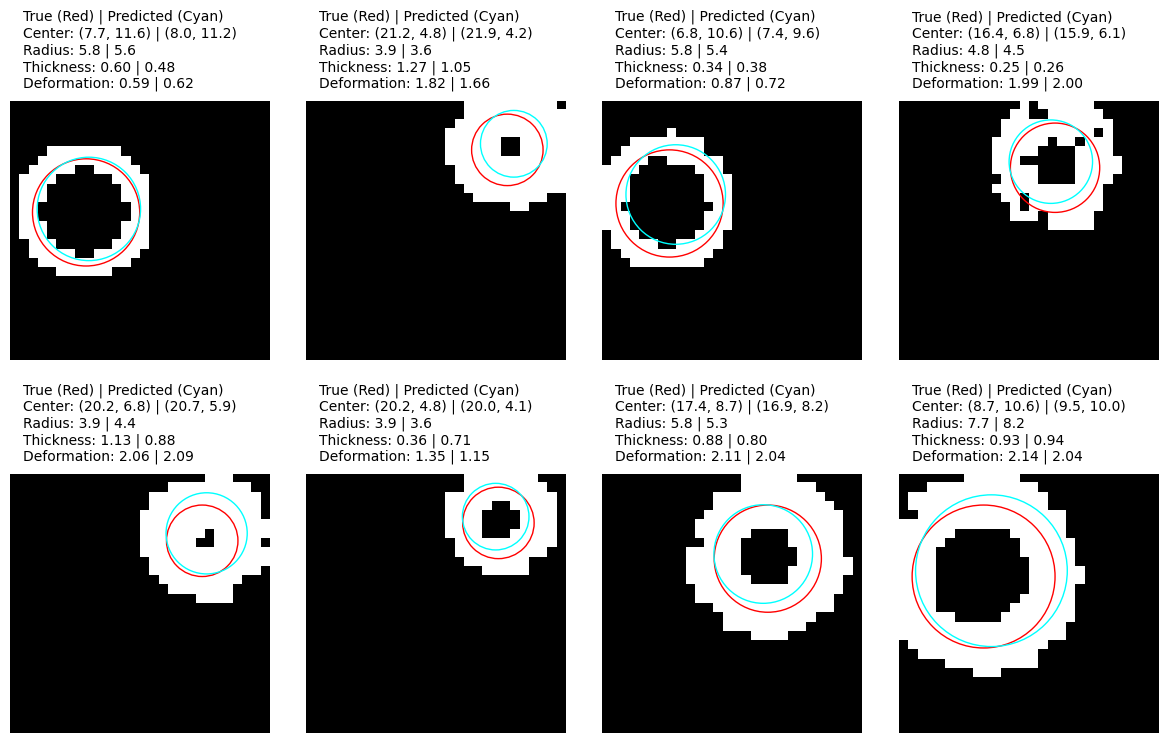

In [10]:
img_size = int(np.sqrt(val_images[0].shape[0]))

# Plot prediction examples
plot_prediction_examples(model, val_images, val_labels, img_size, 8)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


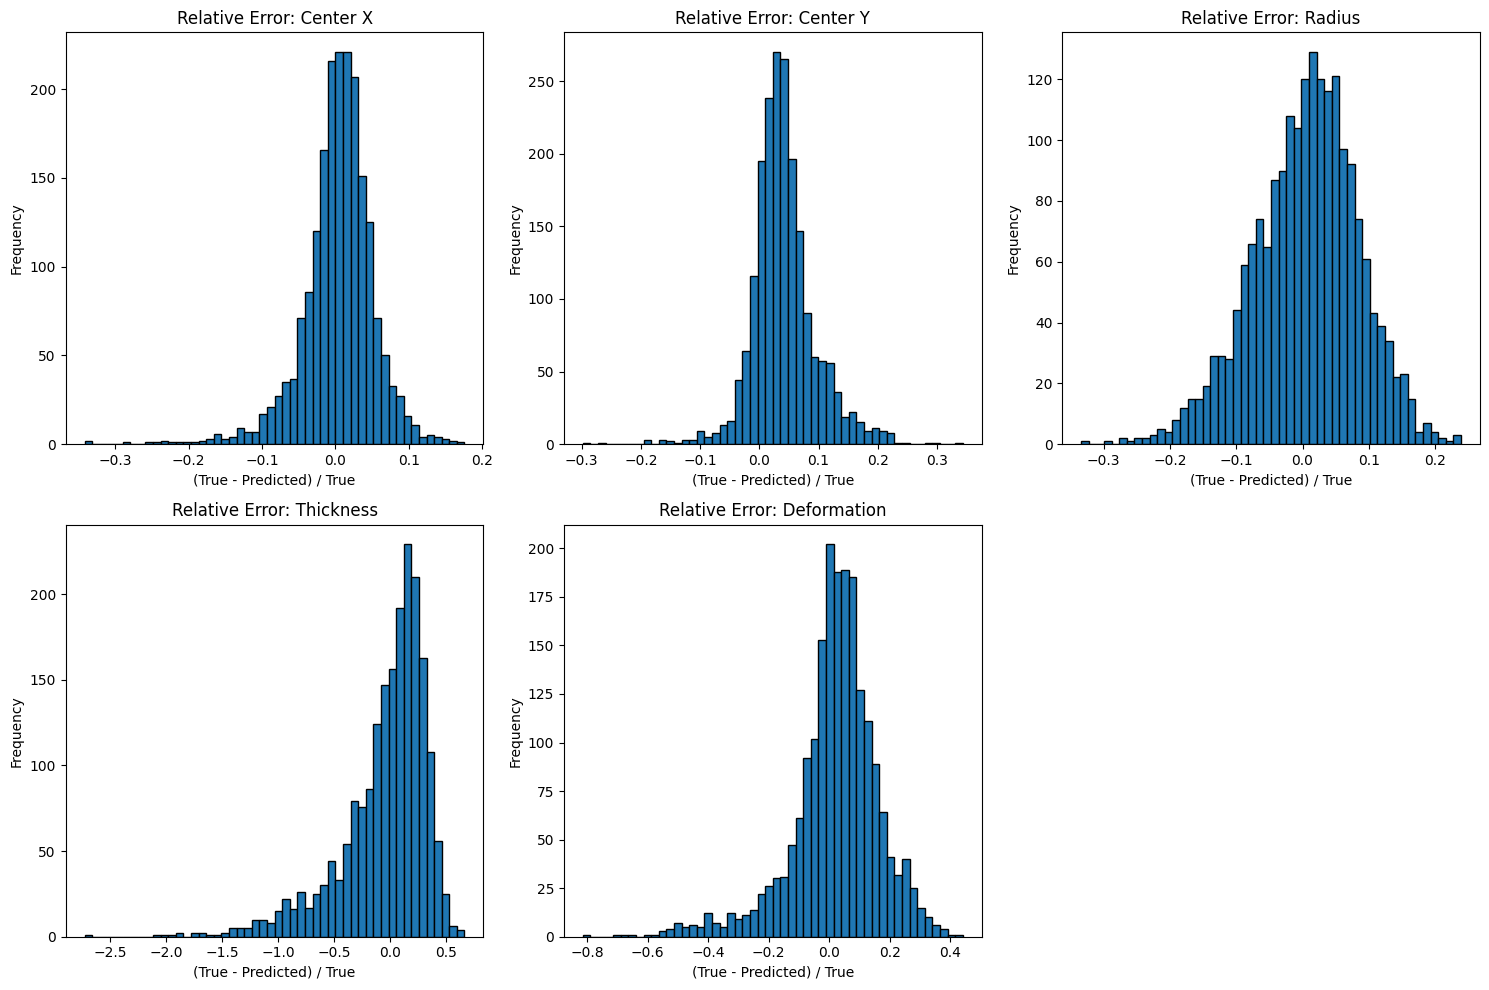

In [11]:
# Get predictions for all validation data
X_test = val_images.reshape(-1, img_size, img_size, 1)
y_true = val_labels
y_pred = model.predict(X_test)

# Plot relative error histograms
plot_relative_error_histograms(y_true, y_pred)

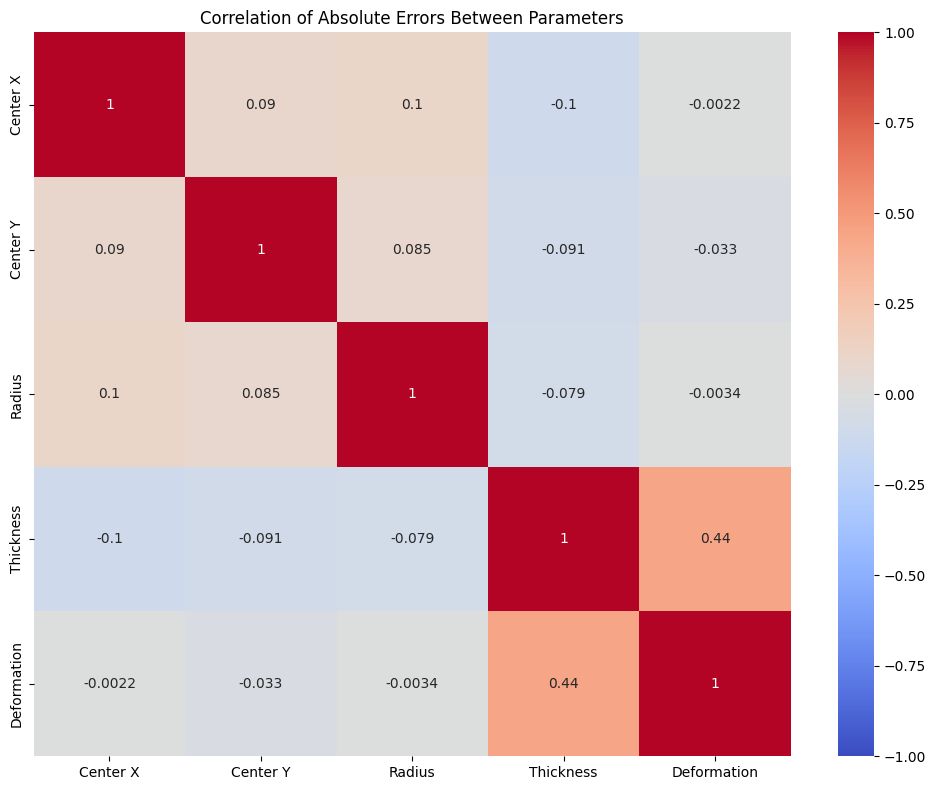

In [12]:
# Plot parameter correlations
plot_parameter_correlations(y_true, y_pred)

### Modify the whole pipeline to introduce a new parameter and learn it!
One idea: Move away from rings and work with ellipses, introducing some exentricity parameter
Can you push it even further? Prove it!

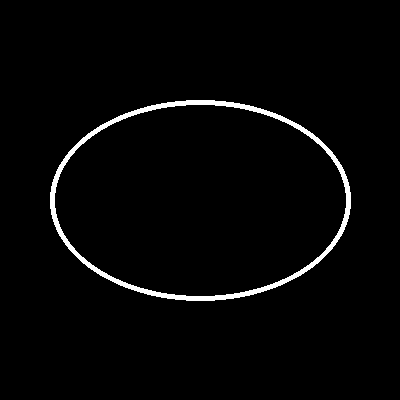

In [38]:
# Example on how to use ellipses:

from PIL import Image, ImageDraw 
from IPython.display import display

# Set up the image
w, h = 400, 400
shape = [(50, 100), (w-50, h-100)] 

# Creating new Image object 
img = Image.new("RGB", (w, h)) 

# Create ellipse image 
img1 = ImageDraw.Draw(img)   
img1.ellipse(shape, outline="white", width=5) 

# Display the image inline
display(img)

### Can you work out some regression without using Neural Networks? How does it compare?
HINT: Explore PCA, SVM and XGBoost